In [4]:
import os, sys, time, resource, re, gc, shutil
from multiprocess import Pool
from functools import partial

from urllib.parse import urlparse, parse_qsl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mongoengine.queryset.visitor import Q
import django
from django.db.models import Count
sys.path.append('/home/galm/software/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.models import *

In [139]:
ytopics = []
y = 1990

run_id = 30
ar = "ar1"
[0,1985,1990.1,1995.1,2001.1,2007.1,2013.1,9999]
ars = [
    {"name":"AR0","years":range(0,1985),"n":0},
    {"name":"AR1","years":range(1985,1991),"n":1},
    {"name":"AR2","years":range(1991,1995),"n":2},
    {"name":"AR3","years":range(1995,2001),"n":3},
    {"name":"AR4","years":range(2001,2008),"n":4},
    {"name":"AR5","years":range(2008,2014),"n":5},
    {"name":"AR6","years":range(2014,9999),"n":6}
]
for ar in ars:   
    ytopics = DocTopic.objects.filter(doc__PY__in=ar["years"],run_id=run_id).values('topic_id').annotate(
        ttotal=models.Sum('score')
    ).values('topic_id','topic__title','ttotal')
    ndf =  pd.DataFrame.from_dict(list(ytopics))
    ndf['AP'] = ar["name"]
    ndf['APn'] = ar["n"]
    if ar["name"]=="AR0":
        df = ndf
    else:
        df = df.append(ndf)

        print(df.head())
    

                topic__title  topic_id    ttotal   AP  APn
0  {rainfal, monsoon, event}       133  0.002014  AR0    0
1     {fuel, vehicl, fossil}       128  0.003607  AR0    0
2  {temperatur, degre, warm}        96  0.012211  AR0    0
3   {ecosystem, veget, flux}       118  0.001546  AR0    0
4  {delta, isotop, thousand}       125  0.001531  AR0    0
                topic__title  topic_id    ttotal   AP  APn
0  {rainfal, monsoon, event}       133  0.002014  AR0    0
1     {fuel, vehicl, fossil}       128  0.003607  AR0    0
2  {temperatur, degre, warm}        96  0.012211  AR0    0
3   {ecosystem, veget, flux}       118  0.001546  AR0    0
4  {delta, isotop, thousand}       125  0.001531  AR0    0
                topic__title  topic_id    ttotal   AP  APn
0  {rainfal, monsoon, event}       133  0.002014  AR0    0
1     {fuel, vehicl, fossil}       128  0.003607  AR0    0
2  {temperatur, degre, warm}        96  0.012211  AR0    0
3   {ecosystem, veget, flux}       118  0.001546  AR0   

In [241]:
df['x'] = df.apply(lambda x: x['APn']+(np.random.rand()-0.5)*0.5,axis=1)
df['change'] = df.ttotal - df.groupby(['topic__title']).ttotal.shift(1)
df['pchange'] = (df.ttotal - df.groupby(['topic__title']).ttotal.shift(1)) / df.groupby(['topic__title']).ttotal.shift(1) * 100

print(df[df.topic_id==115].head(125))

            topic__title  topic_id     ttotal   AP  APn         x     change  \
0  {sea, level, coastal}       115   0.400489  AR1    1  0.989759        NaN   
0  {sea, level, coastal}       115   6.739229  AR2    2  2.020352   6.338740   
0  {sea, level, coastal}       115  16.155914  AR3    3  2.871989   9.416685   
0  {sea, level, coastal}       115  43.150527  AR4    4  4.205986  26.994613   
0  {sea, level, coastal}       115  95.716131  AR5    5  5.017047  52.565604   
0  {sea, level, coastal}       115  74.885842  AR6    6  6.170024 -20.830290   

       pchange  
0          NaN  
0  1582.749783  
0   139.729400  
0   167.088119  
0   121.819149  
0   -21.762569  


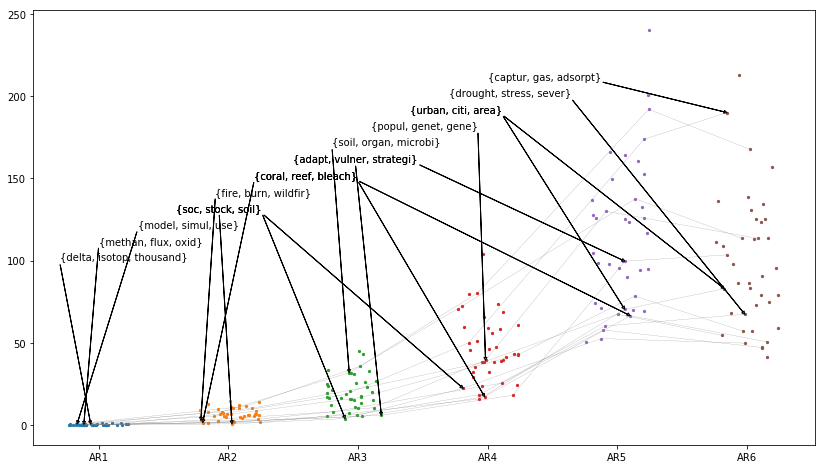

In [244]:
plt.rcParams["figure.figsize"] = [14,8]

topts = []

annotate = True

for ar in ars:
    topar = df[df.AP==ar["name"]].sort_values(by='pchange', ascending=0).reset_index(drop=True)
    if ar["n"] > 0:
        plt.scatter(topar.x,topar.ttotal,s=5)
        i = 0
        for index, t in topar.head(3).iterrows():
            
            if t.topic_id in topts:
                i = topts.index(t.topic_id)
            else:
                topts.append(t.topic_id)
                i = topts.index(t.topic_id)
            if annotate:
                plt.annotate(
                    t.topic__title,
                    #t.topic__title.replace(',','\n') + " (+{}%)".format(round(t.pchange*100)),
                    xy=(t.x,t.ttotal),
                    xytext=(0.7+i*0.3,100+i*10),
                    arrowprops=dict(facecolor='grey',width=0.005,headwidth=3,headlength=3),
                )
            else:
                plt.text(
                    t.x,
                    t.ttotal,
                    str(t.topic_id) #+ " (+{}%)".format(round(t.pchange*100))                
                )
        #for index, t in topar.tail().iterrows():
        #    plt.text(t.x,t.ttotal,t.topic__title)
        
tops = df[df.topic_id.isin(topts)]
tops = tops[tops.APn>0]

for name, group in tops.groupby(['topic_id']):
    plt.plot(group.x,group.ttotal,c="grey",lw=0.2)
    
plt.xticks([1,2,3,4,5,6],["AR1","AR2","AR3","AR4","AR5","AR6"])

wide = tops.pivot(index='topic__title',columns='AP',values='pchange').reset_index()
wide.columns.name = ''
wide= wide.reset_index(drop=True)

wider = tops[['topic_id','topic__title']].drop_duplicates().merge(wide,how="left").sort_values(by='topic_id')

i = 0
if not annotate:
    for index, t in wider.iterrows():
        i+=1
        plt.text(0.7,250-i*10,"{} : {}".format(t.topic_id,t.topic__title))
        
plt.savefig('../plots/hotpng',bbox_inches='tight')             
plt.show()

